<div align="center">

# 🧠 Machine Learning Models

###  **Artin Tavasoli** 👋🏻 
📘 **Student ID:** `810102543`

</div>


<div align="left">

#### 📚 Import Needed Libraries

</div>


In [487]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


<div align="left">

#### ⏳ Load Dataset

</div>


In [488]:
grades_df = pd.read_csv('AI-Course-Grades.csv')

<div align="left">

# 📤 Data Preprocessing

</div>


<div align="left">

### 🧩 Handling Missing Values

#### 👻 Handle Absent Data

</div>


In [489]:
print(grades_df.isnull().any())

university           False
sex                  False
age                  False
address              False
motherEducation      False
fatherEducation      False
motherJob            False
fatherJob            False
reason               False
travelTime           False
studyTime            False
failures             False
universitySupport    False
paid                 False
higher               False
internet             False
romantic             False
freeTime             False
goOut                False
Dalc                 False
Walc                 False
absences             False
EPSGrade             False
DSGrade              False
finalGrade           False
dtype: bool


<div align="left">

#### ❗ Handle Unassigned Values
There are several strategies for dealing with missing data, each suited to different circumstances:

1. Remove Rows with Missing Values: This involves discarding data points (rows) that have missing entries. While simple, it's often impractical if many data points have missing features or if those points contain otherwise valuable information.

2. Remove Columns with Missing Values: This approach drops the entire feature (column) when only a small portion of the dataset contains values for it. It's useful when the missing data renders the feature unreliable or irrelevant.

3. Impute with Statistical Measures: Missing values can be filled using statistical metrics such as the mean, median, or mode of the corresponding column. This method is simple and maintains the dataset's size, though it may introduce bias.

4. Predict Missing Values Using Machine Learning: A supervised learning model, such as a classification or k-nearest neighbors (KNN) model, can predict missing values using patterns in the existing data. This method is more sophisticated and potentially more accurate.

5. Manual Imputation Based on Domain Knowledge: In some cases, domain experts can analyze the data and assign missing values based on contextual understanding or existing labels.


</div>


In [490]:
print('number of unassigned values in 'f"{grades_df.shape[0]} data points")

print((grades_df == 'other').sum())

number of unassigned values in 397 data points
university             0
sex                    0
age                    0
address                0
motherEducation        0
fatherEducation        0
motherJob            142
fatherJob            217
reason                37
travelTime             0
studyTime              0
failures               0
universitySupport      0
paid                   0
higher                 0
internet               0
romantic               0
freeTime               0
goOut                  0
Dalc                   0
Walc                   0
absences               0
EPSGrade               0
DSGrade                0
finalGrade             0
dtype: int64



<span style="font-size:24px; font-weight:bold; color:pink;">About 36% of motherJob and 55% of fatherJob values' are missing, removing these features is the best action here</span>


In [491]:
del grades_df['motherJob']
del grades_df['fatherJob']
print((grades_df == 'other').sum())

university            0
sex                   0
age                   0
address               0
motherEducation       0
fatherEducation       0
reason               37
travelTime            0
studyTime             0
failures              0
universitySupport     0
paid                  0
higher                0
internet              0
romantic              0
freeTime              0
goOut                 0
Dalc                  0
Walc                  0
absences              0
EPSGrade              0
DSGrade               0
finalGrade            0
dtype: int64


<span style="font-size:24px; font-weight:bold; color:pink;">assign values to "reason" feature: </span>

if travel time is less than 15 minutes of travel time then the reason probably was how close this university is to it's home

break these datapoints into three groups based on their universities (CM or PR) and create 2 panda dataframe for each one

    for the remaining unassigned reasons in each newly created dataframe:

        if mod reason column was reputation (the most seen reason was reputation)

            put reason['other'] to 'reputation' because  this means the university was a very reputable one and others probably chose the same reason

        else
        
            put reason['other'] = course


In [492]:
def assign_reasons(df):
    df['original_reason'] = df['reason']

    mask = df['reason'] == 'other'
    df.loc[mask, 'reason'] = np.where(
    df.loc[mask, 'travelTime'] == 1,
    'home',
    np.where(
        df.loc[mask, 'original_reason'] == 'reputation',
        'reputation',
        'course'
    )
    )


    mask = df['reason'] == 'other'
    reason_counts = df['reason'].value_counts()
    if reason_counts.get('reputation') > reason_counts.get('course'):
        df.loc[mask, 'reason'] = 'reputation'
    else:
        df.loc[mask, 'reason'] = 'course'
    df.drop(columns='original_reason', inplace=True)
    return df

df_cm = grades_df[grades_df['university'] == 'CM'].copy()
df_pr = grades_df[grades_df['university'] == 'PR'].copy()
df_cm = assign_reasons(df_cm)
df_pr = assign_reasons(df_pr)

print("CM head:\n", df_cm[['university','travelTime','reason']].head(), "\n")
print("PR head:\n", df_pr[['university','travelTime','reason']].head())
df_cm.to_csv('df_cm.csv', index=False)
grades_df = pd.concat([df_pr, df_cm], ignore_index=True)

CM head:
     university  travelTime  reason
349         CM           2  course
350         CM           3    home
351         CM           2  course
352         CM           1  course
353         CM           3    home 

PR head:
   university  travelTime  reason
0         PR           2  course
1         PR           1  course
2         PR           1    home
3         PR           1    home
4         PR           1    home


clean data
abscenses can be from 0 to 93, classify them into 4 groups:

0 : 0-2

1 : 3-5

2 : 6-9

3 : 10 or more

EPSGrade,DSGrade,finalGrade classify them into 4 groups:

0 : 10 or lower

1 : 10-14

2 : 14-17

3 : 17 or more


In [493]:
def classify_absences(number_of_absences):
    if number_of_absences <= 2:
        return 0
    elif number_of_absences <= 5:
        return 1
    elif number_of_absences <= 9:
        return 2
    else:
        return 3

def classify_grade(grade):
    if grade <= 10:
        return 0
    elif grade <= 14:
        return 1
    elif grade <= 17:
        return 2
    else:
        return 3

grades_df['absences'] = grades_df['absences'].apply(classify_absences)
grades_df['EPSGrade'] = grades_df['EPSGrade'].apply(classify_grade)
grades_df['DSGrade'] = grades_df['DSGrade'].apply(classify_grade)
grades_df['finalGrade'] = grades_df['finalGrade'].apply(classify_grade)

print(grades_df.head())

  university sex  age address  motherEducation  fatherEducation  reason  \
0         PR   F   18       U                4                4  course   
1         PR   F   17       U                1                1  course   
2         PR   F   15       U                1                1    home   
3         PR   F   15       U                4                2    home   
4         PR   F   16       U                3                3    home   

   travelTime  studyTime  failures  ... internet romantic freeTime goOut Dalc  \
0           2          2         0  ...       no       no        3     4    1   
1           1          2         0  ...      yes       no        3     3    1   
2           1          2         3  ...      yes       no        3     2    2   
3           1          3         0  ...      yes      yes        2     2    1   
4           1          2         0  ...       no       no        3     2    1   

   Walc  absences  EPSGrade  DSGrade  finalGrade  
0     1    

use label encoding

In [494]:
cat_cols = grades_df.select_dtypes(include=['object','category']).columns.tolist()


for col in cat_cols:
    grades_df[col] = grades_df[col].astype('category')

for col in cat_cols:
    grades_df[col] = grades_df[col].cat.codes

print(grades_df.head())


   university  sex  age  address  motherEducation  fatherEducation  reason  \
0           1    0   18        1                4                4       0   
1           1    0   17        1                1                1       0   
2           1    0   15        1                1                1       1   
3           1    0   15        1                4                2       1   
4           1    0   16        1                3                3       1   

   travelTime  studyTime  failures  ...  internet  romantic  freeTime  goOut  \
0           2          2         0  ...         0         0         3      4   
1           1          2         0  ...         1         0         3      3   
2           1          2         3  ...         1         0         3      2   
3           1          3         0  ...         1         1         2      2   
4           1          2         0  ...         0         0         3      2   

   Dalc  Walc  absences  EPSGrade  DSGrade  finalG

Train and Test Split

In [495]:
SPLIT_RATIO = 0.2
X = grades_df.drop('finalGrade', axis=1)
Y = grades_df['finalGrade']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=SPLIT_RATIO, random_state=67, shuffle=True)
print('length X train is : ', len(X_train))
print('length X test is : ', len(X_test))

length X train is :  317
length X test is :  80


<span style="font-size:24px; font-weight:bold; color:pink;">Standardise Numerical Features</span>

Why Standardization is important?
    
    Scalling ensures features with large numeric range won't dominate other features. Many machine learning models are sensitive to distance metrics for example KNN, by 
    
    scaling we'll prevent biased features, avoid slowed convergence and lead to overall better perfomance.

Methods:

    1. Min-Max Scaling:

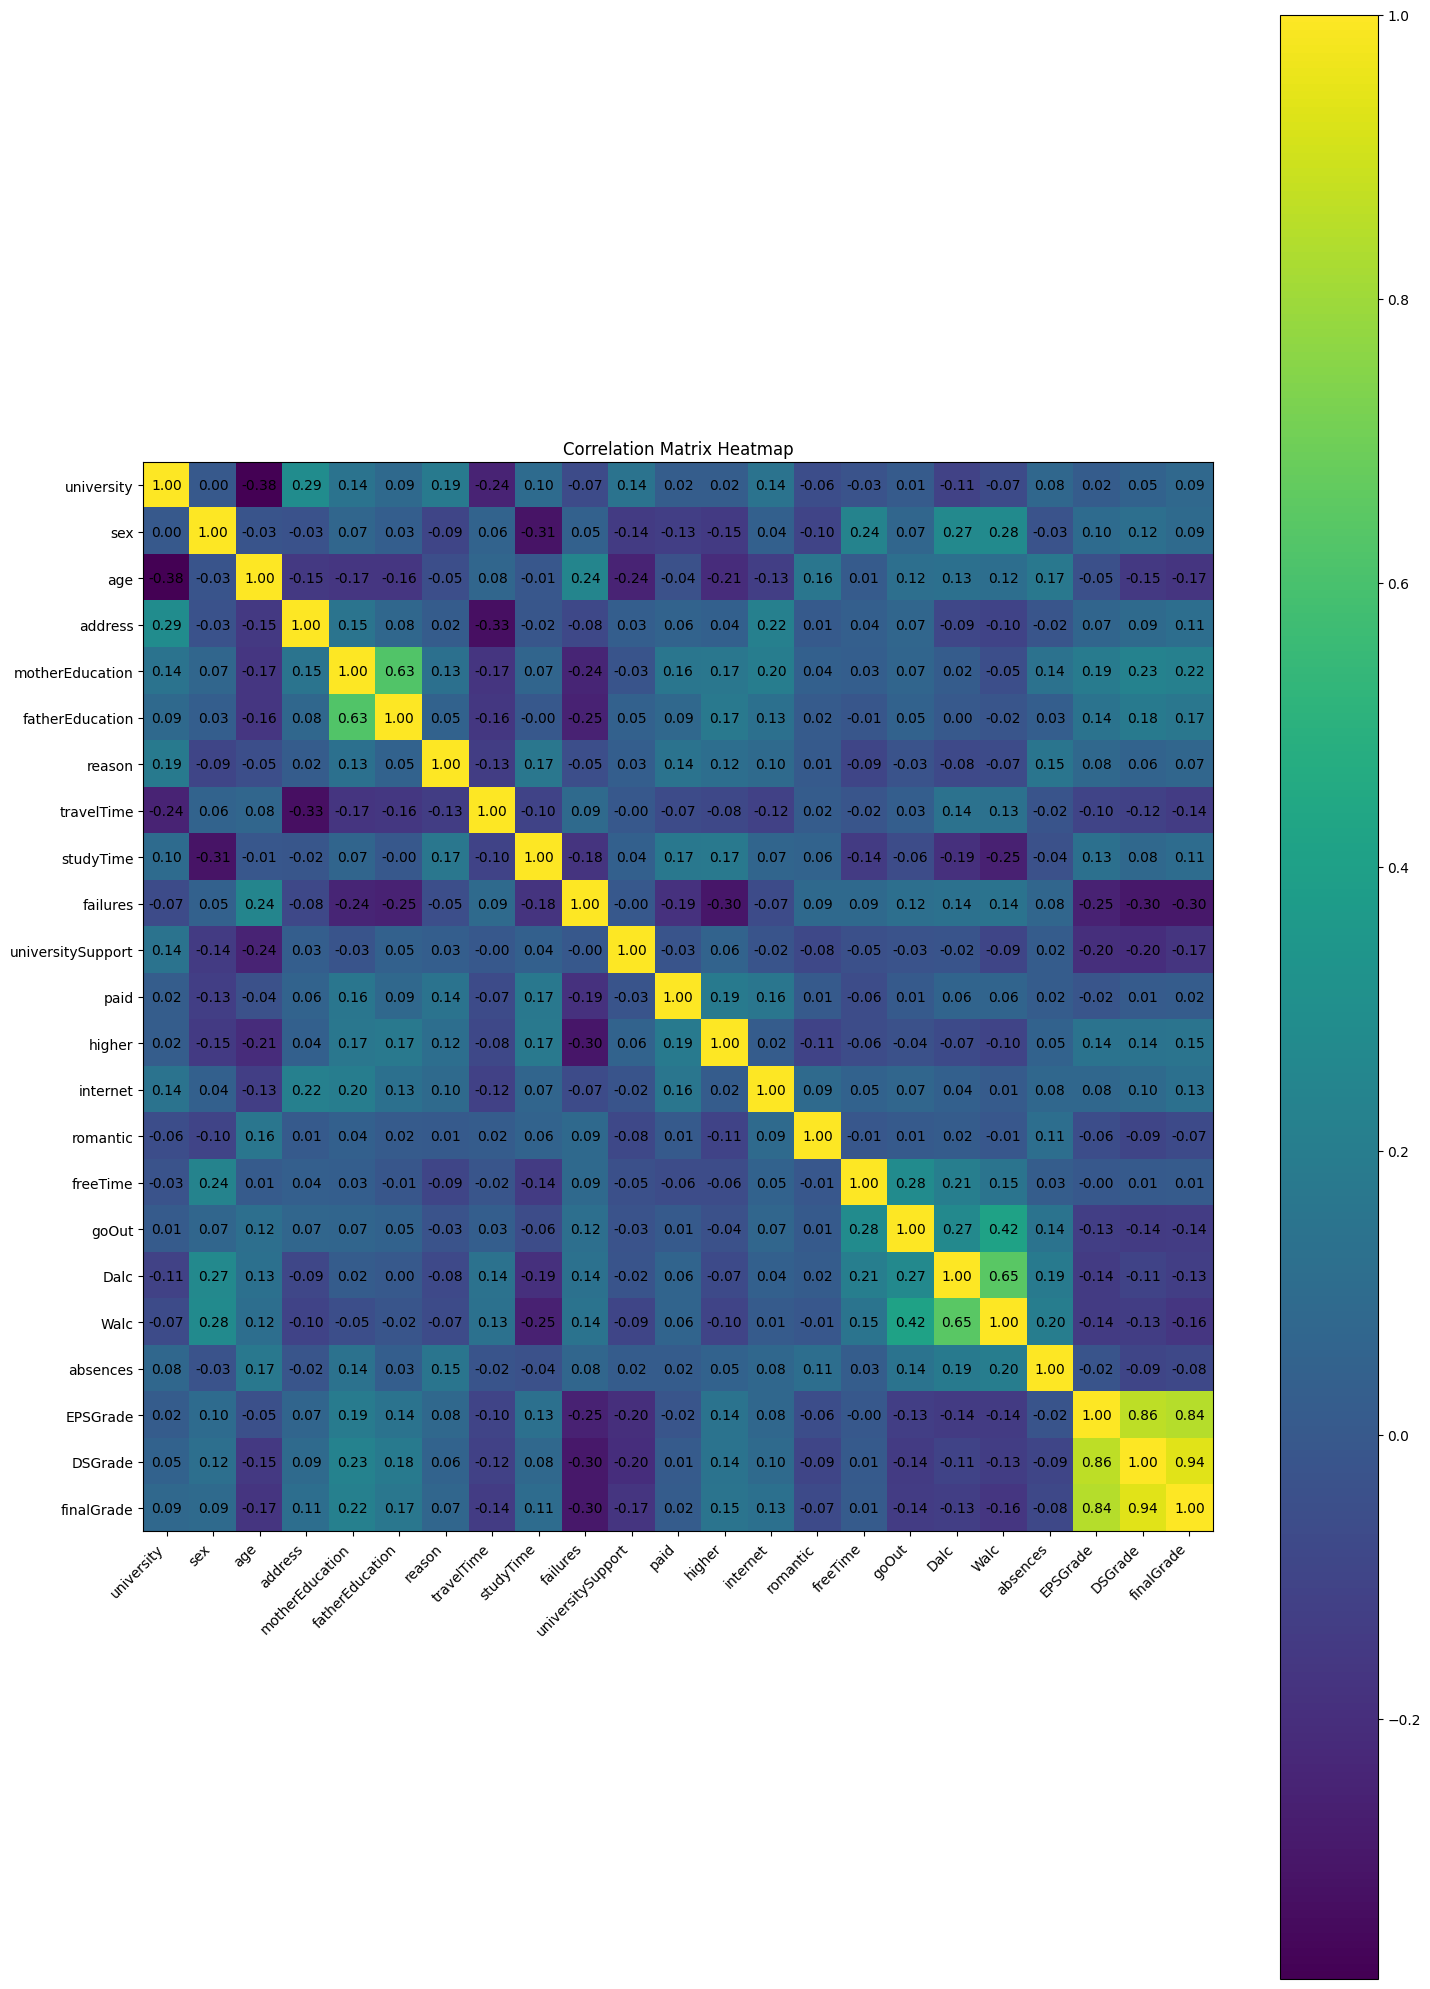

In [496]:
import matplotlib.pyplot as plt

# 1) Compute the correlation matrix
corr = grades_df.corr()

# 2) Plot it with imshow (default colormap)
fig, ax = plt.subplots(figsize=(15, 20))
cax = ax.imshow(corr, interpolation='nearest')

# 3) Label the axes
cols = corr.columns
ax.set_xticks(range(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha='right')
ax.set_yticks(range(len(cols)))
ax.set_yticklabels(cols)

# 4) Annotate each cell with its value
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha='center', va='center')

# 5) Add title & colorbar
plt.title('Correlation Matrix Heatmap')
plt.colorbar(cax)
plt.tight_layout()
plt.show()


EPSGrade and DSGrade are the two most correlated feature with finalGrade; plot a scatter figure using these two features

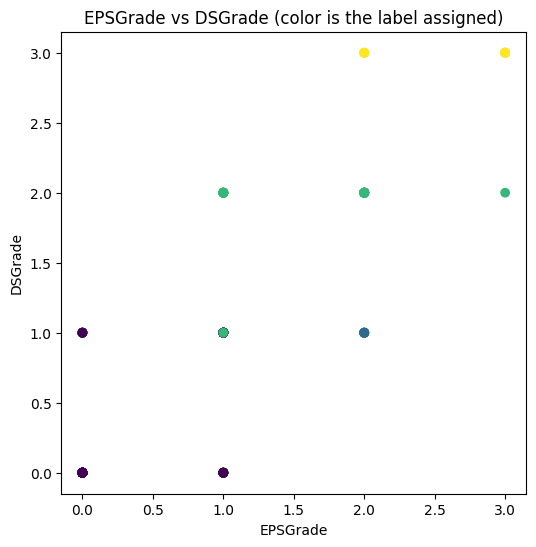

In [497]:
plt.figure(figsize=(6,6))
plt.scatter(X_train['EPSGrade'], X_train['DSGrade'], c=Y_train)
plt.xlabel('EPSGrade')
plt.ylabel('DSGrade')
plt.title(f"{'EPSGrade'} vs {'DSGrade'} (color is the label assigned)")
plt.show()

<span style="font-size:24px; font-weight:bold; color:pink;">Standardise Numerical Features</span>

Why Standardization is important?
    
    Scalling ensures features with large numeric range won't dominate other features. Many machine learning models are sensitive to distance metrics for example KNN, by 
    
    scaling we'll prevent biased features, avoid slowed convergence and lead to overall better perfomance.

Methods:

    1. Standardization: Scales features to have a mean of 0 and a standard deviation of 1. Suited for when features are approximately Gaussian (Normal distribution).

    2. Min-Max Scaling: Scales features to a range between [0, 1]. Suited for when you want bounded inputs but also preserve original distribution of features.

    3. Robust Scaling: median=0, IQR=1. Suited for when data contains strong outliers

    4. Logarithmic Transform: Suited for taming long tails. By compressing large values and expanding small ones, we'll get a more symmetric distribution.

Which is most suited here:

        according to observed scatter plot we don't have strong outliers and also our features values are pretty symmetric so neither Robust Scaling or Logarithmic 
        
        Transform are not suited for our dataset. Both Standardization and Min-Max Scaling need to be analysed.

In [498]:
numerical_columns = ['age']

# scaler = preprocessing.StandardScaler()
# grades_df[numerical_columns] = scaler.fit_transform(grades_df[numerical_columns])

scaler = preprocessing.MinMaxScaler()
grades_df[numerical_columns] = scaler.fit_transform(grades_df[numerical_columns])

grades_df[numerical_columns].head()

,age
0,0.428571
1,0.285714
2,0.000000
3,0.000000
4,0.142857
